Importação das Bibliotecas

In [1]:
import os
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import multiprocessing
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, 
    BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate,
    RandomContrast
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-07-23 21:05:14.116748: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-23 21:05:14.119174: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 21:05:14.172606: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 21:05:14.173704: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 21:05:15.204196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Esse código é para a utilização de todos os processadores

In [2]:
num_cores = multiprocessing.cpu_count()
config = tf.compat.v1.ConfigProto(inter_op_parallelism_threads=num_cores,
                                  intra_op_parallelism_threads=num_cores)
tf.compat.v1.Session(config=config)


Inicialização das Variáveis que seram utilizadas dirante a execução do código

In [3]:
IMG_HEIGHT = 64
IMG_WIDTH = IMG_HEIGHT
IMG_CHANNELS = 2

batch_size = 64
epochs = 3

Carrega os dados de treinamento

In [4]:
# Defina o diretório onde os arquivos foram salvos
path = "/home/cristiano/Imagens/"

diretorio_imagens =  path + "imagens_originais/Sentinel-2/treino_processadas/"

# Caminhos completos para os arquivos X_train.npy e Y_train.npy
X_train_file = os.path.join(diretorio_imagens, 'X_train.npy')
Y_train_file = os.path.join(diretorio_imagens, 'Y_train.npy')

# Carregar os dados de volta para o notebook
X_train = np.load(X_train_file)
Y_train = np.load(Y_train_file)

# Verificar a forma (shape) das arrays carregadas
print('Shape de X_train:', X_train.shape)
print('Shape de Y_train:', Y_train.shape)


Shape de X_train: (2069, 64, 64, 2)
Shape de Y_train: (2069, 64, 64, 1)


Estrutura da Rede U-Net

In [7]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

Cria e complita a rede

In [9]:
my_unet = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
my_unet.compile(optimizer=Adam(learning_rate=1e-4),  loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization

In [10]:
def build_segnet(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(n_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(inputs, x)
    return model

In [11]:
my_segnet = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
my_segnet.compile(optimizer=Adam(learning_rate=1e-4),  loss='binary_crossentropy', metrics=['accuracy'])

NameError: name 'build_unet' is not defined

In [ ]:
filepath = diretorio_imagens + "model70-30.h5"
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystopper, checkpoint]
history = my_segnet.fit(X_train, Y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)

Visualização da estrutura criada

In [10]:
print(my_unet.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 2)]          0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 64, 64, 64)           1216      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 64, 64, 64)           256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 64, 64, 64)           0         ['batch_normalization_18[0

Inicializa o treinamento e salva o resultado 

In [11]:
filepath = diretorio_imagens + "model70-30.h5"
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystopper, checkpoint]
history = my_unet.fit(X_train, Y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, callbacks=callbacks_list)

Epoch 1/3
26/26 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.9268
Epoch 1: val_loss improved from inf to 0.64957, saving model to /home/cristiano/Imagens/imagens_originais/Sentinel-2/treino_processadas/model70-30.h5


/home/cristiano/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 233s 9s/step - loss: 0.4803 - accuracy: 0.9268 - val_loss: 0.6496 - val_accuracy: 0.9992
Epoch 2/3
26/26 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9926
Epoch 2: val_loss improved from 0.64957 to 0.58212, saving model to /home/cristiano/Imagens/imagens_originais/Sentinel-2/treino_processadas/model70-30.h5
26/26 [==============================] - 211s 8s/step - loss: 0.2452 - accuracy: 0.9926 - val_loss: 0.5821 - val_accuracy: 1.0000
Epoch 3/3
26/26 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9981
Epoch 3: val_loss improved from 0.58212 to 0.50509, saving model to /home/cristiano/Imagens/imagens_originais/Sentinel-2/treino_processadas/model70-30.h5
26/26 [==============================] - 233s 9s/step - loss: 0.1775 - accuracy: 0.9981 - val_loss: 0.5051 - val_accuracy: 1.0000


Salva as métricas da rede já treinada

In [12]:
# Salvar o objeto 'history' 
history_file = diretorio_imagens + "history.pkl"
with open(history_file, 'wb') as file:
    pickle.dump(history.history, file)


In [13]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Visualização dos Gráficos de Precisão e Perda

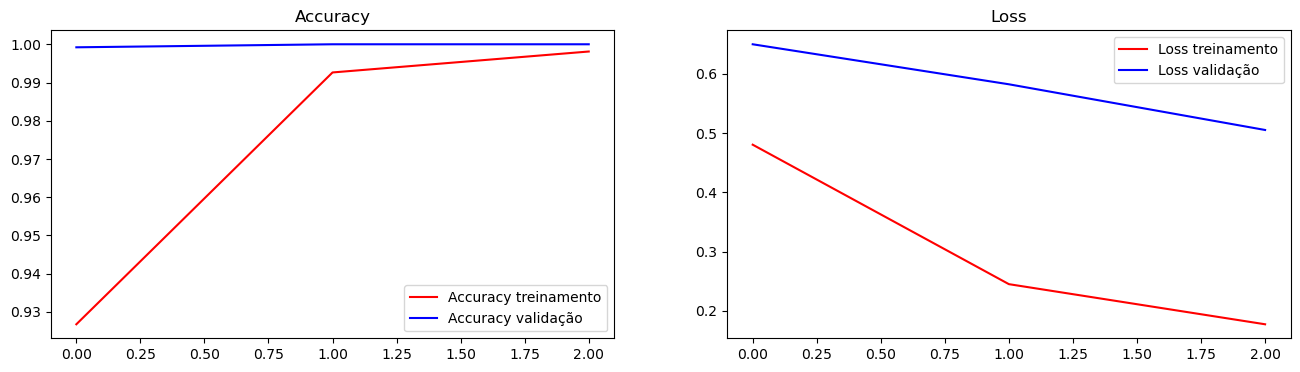

In [15]:
def mostrar_graficos(history):
  fig = plt.gcf()
  fig.set_size_inches(16,4)
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], 'red', label='Accuracy treinamento')
  plt.plot(history.history['val_accuracy'], 'blue', label='Accuracy validação')
  plt.legend()
  plt.title('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], 'red', label='Loss treinamento')
  plt.plot(history.history['val_loss'], 'blue', label='Loss validação')
  plt.legend()
  plt.title('Loss')
  
  plt.show()

mostrar_graficos(history)